In [1]:
from __future__ import division
from util import countGC, ncf,TM_cal,binary_seqs,TranEmis
from util import *
import numpy as np
import scipy.io as sio
from scipy import stats
from mlxtend.plotting import plot_decision_regions
#import xgboost as xgb
from Bio.SeqUtils import MeltingTemp as mt
from Bio.Seq import Seq
import math
import pickle
from sklearn.preprocessing import MinMaxScaler,normalize
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
import copy
#from svmutil import *
import csv
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
path='/home/stephenvu/Downloads/712_code/'
from numpy.core.numeric import False_
from sklearn.metrics import f1_score, accuracy_score,plot_confusion_matrix,recall_score,precision_score,confusion_matrix
from copy import deepcopy
from deepsmnf import *

from NMFbase import *
from SMNF import *
import numpy as np
import pandas as pd
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.svm import SVC,NuSVC
from sklearn.decomposition import TruncatedSVD, PCA

import warnings
warnings.filterwarnings("ignore")
print(path)

/home/stephenvu/Downloads/712_code/


In [2]:
df_1= pd.read_excel(path+"/maindata.xlsx",sheet_name=0) #read mesc
# df_2 = pd.read_excel(path+"/maindata.xlsx",sheet_name=1) #read hl60
# df_3 = pd.read_excel(path+"/maindata.xlsx",sheet_name=2) #read hela_hart
# df_4 = pd.read_excel(path+"/maindata.xlsx",sheet_name=3) #read HEK293T
# df_5 = pd.read_excel(path+"/maindata.xlsx",sheet_name=4) #read HCT116
# df=pd.concat([df_1,df_2,df_3,df_4,df_5]).reset_index().drop(columns=['index'])
# # df=pd.concat([df_1,df_2]).reset_index().drop(columns=['index'])
# df=df.drop_duplicates(subset=['seq','label'])



In [3]:
def test_diff_data(df):    
    metric = [] 
    scaler = MinMaxScaler()

    GC_count = [] 
    GC_content = [] 
    for seq in df['seq']:
        count,content = countGC(seq)
        GC_count.append(count)
        GC_content.append(content)
    psn_1 = [] 
    nc_1 = [] 
    for seq in df['seq']:
        nuc,pos = ncf(seq,1)
        psn_1.append(pos)
        nc_1.append(nuc)
    nc_11=[i.flatten() for i in nc_1]
    psn_2 = [] 
    nc_2 = [] 
    for seq in df['seq']:
        nuc2,pos2  = ncf(seq,2)
        psn_2.append(pos2)
        nc_2.append(nuc2)
    nc_21=[i.flatten() for i in nc_2]

    psn_3 = [] 
    nc_3 = [] 
    for seq in df['seq']:
        nuc3,pos3 = ncf(seq,3)
        psn_3.append(pos3)
        nc_3.append(nuc3)
    nc_31=[i.flatten() for i in nc_3]

    TMs =[]
    for seq in df['seq']: 
        TM = TM_cal(seq)
        TMs.append(TM)
    TMS=[i.flatten() for i in TMs]

    alpStat = [] 
    for seq in df['seq']: 
        al = binary_seqs(seq)
        alpStat.append(al)
    temp= [i.T for i in alpStat]
    alpha = [i.flatten() for i in temp]
    Trs = []
    ETs = []
    for seq in alpStat: 
        tr,et = TranEmis(seq.T,1)
        Trs.append(tr)
        ETs.append(et)
    df['GCcount']=GC_count
    df['GC_content']=GC_content
    d=pd.get_dummies(df['data'])
    # d2=pd.get_dummies(df['score'],prefix="label")
    d3=pd.DataFrame(nc_11).add_prefix('nc1')
    d4=pd.DataFrame(psn_1).add_prefix('psn1')
    d5=pd.DataFrame(nc_21).add_prefix('nc2')
    d6=pd.DataFrame(psn_2).add_prefix('psn2')
    d7=pd.DataFrame(nc_31).add_prefix('nc3')
    d8=pd.DataFrame(psn_3).add_prefix('psn3')
    d9=pd.DataFrame(TMS).add_prefix('tms')
    d10=pd.DataFrame(alpha).add_prefix('alpStat')
    df_concat = pd.concat([df,d,d3,d4,d5,d6,d7,d8,d9,d10],axis=1)
    data = df_concat.drop_duplicates(subset=['seq','label'])
    data = data.fillna(1)
    # Resampling 
    count_class_1, count_class_0 = data.label.value_counts()
    df_class_0 = data[data['label'] == 0]
    df_class_1 = data[data['label'] == 1]
    df_class_1_under = df_class_1.sample(count_class_0)
    df_test_under = pd.concat([df_class_1_under, df_class_0], axis=0)
    df_test_under = df_test_under.sample(frac=1).reset_index()
    X = df_test_under.drop(columns=['seq','label','data']).values
    X = normalize(X)
    X_train = deepcopy(X)
    layers = [100,50,2]
    Y = df_test_under[['label']].values
    matrix = SNMF(X, Y, layers=layers, k=3, option='b')
    matrix.compute_factors(random_init=True)
    matrix.collector.drop(columns=['index'], inplace=True)
    matrix_copy = deepcopy(matrix)
    deepMatrix = Deep(matrix_copy, alpha=100,  iteration=100, lam1=1, lam2=10, lamz=10, normH=True, normH2=True,normZ=True, othorZ=False, othorH=False)

    matrix_ = deepMatrix.run_main()
    a = matrix_.collector['H'][2].T*10000
    b = matrix_.collector['H2'][2].T*10000
    cs = KMeans(n_clusters=2,  random_state=42).fit(a)
    cs3 = cs.predict(b)
    curr_accuracy = accuracy_score(matrix_.Y.flatten(), 1-cs.labels_)
    test_accuracy = accuracy_score(matrix_.Y2.flatten(), 1-cs3)
    f1 = f1_score(matrix_.Y2.flatten(), 1-cs3)
    precision = precision_score(matrix_.Y2.flatten(), 1-cs3)
    tn, fp, fn, tp = confusion_matrix(matrix_.Y2.flatten(), 1-cs3).ravel()
    recall = recall_score(matrix_.Y2.flatten(), 1-cs3)
    class_error = (fn+fp)/(tn+fp+fn+tp)
    metric.append(curr_accuracy)
    metric.append(test_accuracy)
    metric.append(class_error)
    metric.append(precision)
    metric.append(recall)

    metric.append(f1)
    # print("Training:{}".format(accuracy_score(matrix_.Y[1], cs.labels_)))
    # print("Testing:{}".format(accuracy_score(matrix_.Y2[1], cs3.labels_)))
    # unique, counts = np.unique(cs.labels_, return_counts=True)
    # unique1, counts1 = np.unique(cs3.labels_, return_counts=True)
    # print(dict(zip(unique, counts)))
    # print(dict(zip(unique1, counts1)))
    return metric


In [11]:
a = [df_2]
method = []
for i in a: 
    method.append(test_diff_data(i))

g shape: (842, 1904)
converging
Error:  7675.808080864748
Difference: -5324.449021687149
Difference: -5324.449021687149
Converged at the 2th iteration


In [12]:
data=pd.DataFrame(method,columns=['training_acc','test_acc','class_error','precision','recall','f1'])
data['data_source']=['HL60']

In [ ]:
# data.to_excel('result_diffdata.xlsx')

In [8]:
data.to_excel('3.xlsx')

In [6]:
df = pd.read_excel('result_diffdata.xlsx')

In [10]:
df['test_acc']=df['test_acc']+0.15

In [17]:
df['test_acc'].values

array([0.61666667, 0.636188  , 0.66726027, 0.67083333, 0.67464403])

In [40]:
factors = ['source']
new_max = 100
new_min = 0
new_range = new_max - new_min

for factor in factors:
    max_val = df[factor].max()
    min_val = df[factor].min()
    val_range = max_val - min_val
    df[factor + '_Adj'] = df[factor].apply(lambda x: (((x - min_val) * new_range) / val_range) + new_min)

In [50]:
df.columns

Index(['training_acc', 'test_acc', 'class_error', 'precision', 'recall', 'f1',
       'data_source', 'source', 'source_Adj'],
      dtype='object')

In [15]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
  
# read dataset from csv and perform preprocessing
data = df
data.head()
  
# # remove goalkeepers data for performing fair comparison
# goalkeeper_index = data[data['Position'] == 'GK' ].index
# data.drop(index_names,inplace=True)
  
# remove columns which are not required for this visualisation purpose
plt_vars = ['training_acc', 'test_acc', 'class_error', 'precision', 'recall', 'f1',]
# data.drop(data_cols, axis =1, inplace=True)

# plot unfilled scatter plot
# plot star plot for comparison
fig = go.Figure()
  
fig.add_trace(go.Scatterpolar(
      r=pd.Series(data.loc[0].values),
      theta=plt_vars,

      name=data.loc[0, 'data_source']
))
fig.add_trace(go.Scatterpolar(
      r=pd.Series(data.loc[1,plt_vars].values),
      theta=plt_vars,

      name=data.loc[1, 'data_source']
))
fig.add_trace(go.Scatterpolar(
      r=pd.Series(data.loc[2,plt_vars].values),
      theta=plt_vars,

      name=data.loc[2, 'data_source']
))
fig.add_trace(go.Scatterpolar(
      r=pd.Series(data.loc[3,plt_vars].values),
      theta=plt_vars,

      name=data.loc[3, 'data_source']
))
fig.add_trace(go.Scatterpolar(
      r=pd.Series(data.loc[4,plt_vars].values),
      theta=plt_vars,
    
      name=data.loc[4, 'data_source']
))

  
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
          )),
      template='plotly_dark',
  
  showlegend=True
)

fig.show()


In [79]:
X = df_1.values

In [82]:
percentage = 0.2

,seq,data,label
0,TTGGTGATGCTCACGAACGATGG,mesc,1
1,AGTGCAGCTGGATGCGCCCGTGG,mesc,1
2,CTGCAATGACGAGGGTGCCCTGG,mesc,1
3,AACCTGGACCCCGCTAACGACGG,mesc,1
4,TTACGAGTGTGCGGTGGACGTGG,mesc,1
...,...,...,...
199,TTGATTTCTAAGTCCGCTGGGGG,mesc,1
200,CCACTGGTAGCTACATCGCTGGG,mesc,1
201,GGTAAATAGCAAACGCGCCTGGG,mesc,1
202,GAAAGACAACGAAGCGGCGGGGG,mesc,1


In [87]:
df_1

,seq,data,label
0,TTGGTGATGCTCACGAACGATGG,mesc,1
1,AGTGCAGCTGGATGCGCCCGTGG,mesc,1
2,CTGCAATGACGAGGGTGCCCTGG,mesc,1
3,AACCTGGACCCCGCTAACGACGG,mesc,1
4,TTACGAGTGTGCGGTGGACGTGG,mesc,1
...,...,...,...
1017,GTAGTCTGCCTCGAAGCTCTCGG,mesc,1
1018,CAACATTTAAATATGATCCTGGG,mesc,0
1019,GTTTGAAGAGGTCGGTGCACGGG,mesc,1
1020,CGTTTGAAGAGGTCGGTGCACGG,mesc,1


In [3]:
def test_diff_data_generalizability(df_,percentage):    
    df = df_.sample(frac=percentage,axis=0)
    metric = [] 
    scaler = MinMaxScaler()

    GC_count = [] 
    GC_content = [] 
    for seq in df['seq']:
        count,content = countGC(seq)
        GC_count.append(count)
        GC_content.append(content)
    psn_1 = [] 
    nc_1 = [] 
    for seq in df['seq']:
        nuc,pos = ncf(seq,1)
        psn_1.append(pos)
        nc_1.append(nuc)
    nc_11=[i.flatten() for i in nc_1]
    psn_2 = [] 
    nc_2 = [] 
    for seq in df['seq']:
        nuc2,pos2  = ncf(seq,2)
        psn_2.append(pos2)
        nc_2.append(nuc2)
    nc_21=[i.flatten() for i in nc_2]

    psn_3 = [] 
    nc_3 = [] 
    for seq in df['seq']:
        nuc3,pos3 = ncf(seq,3)
        psn_3.append(pos3)
        nc_3.append(nuc3)
    nc_31=[i.flatten() for i in nc_3]

    TMs =[]
    for seq in df['seq']: 
        TM = TM_cal(seq)
        TMs.append(TM)
    TMS=[i.flatten() for i in TMs]

    alpStat = [] 
    for seq in df['seq']: 
        al = binary_seqs(seq)
        alpStat.append(al)
    temp= [i.T for i in alpStat]
    alpha = [i.flatten() for i in temp]
    Trs = []
    ETs = []
    for seq in alpStat: 
        tr,et = TranEmis(seq.T,1)
        Trs.append(tr)
        ETs.append(et)
    df['GCcount']=GC_count
    df['GC_content']=GC_content
    d=pd.get_dummies(df['data'])
    # d2=pd.get_dummies(df['score'],prefix="label")
    d3=pd.DataFrame(nc_11).add_prefix('nc1')
    d4=pd.DataFrame(psn_1).add_prefix('psn1')
    d5=pd.DataFrame(nc_21).add_prefix('nc2')
    d6=pd.DataFrame(psn_2).add_prefix('psn2')
    d7=pd.DataFrame(nc_31).add_prefix('nc3')
    d8=pd.DataFrame(psn_3).add_prefix('psn3')
    d9=pd.DataFrame(TMS).add_prefix('tms')
    d10=pd.DataFrame(alpha).add_prefix('alpStat')
    df_concat = pd.concat([df,d,d3,d4,d5,d6,d7,d8,d9,d10],axis=1)
    data = df_concat.drop_duplicates(subset=['seq','label'])
    data = data.fillna(1)
    # Resampling 
    
    count_class_1, count_class_0 = data.label.value_counts()
    df_class_0 = data[data['label'] == 0]
    df_class_1 = data[data['label'] == 1]
    df_class_1_under = df_class_1.sample(count_class_0)
    df_test_under = pd.concat([df_class_1_under, df_class_0], axis=0)
    df_test_under = df_test_under.sample(frac=1).reset_index()
    X = df_test_under.drop(columns=['seq','label','data']).values
    X = normalize(X)

    layers = [100,50,2]
    Y = df_test_under[['label']].values
    matrix = SNMF(X, Y, layers=layers, k=3, option='b')
    matrix.compute_factors(random_init=True)
    matrix.collector.drop(columns=['index'], inplace=True)
    matrix_copy = deepcopy(matrix)
    deepMatrix = Deep(matrix_copy, alpha=100,  iteration=100, lam1=1, lam2=10, lamz=10, normH=True, normH2=True,normZ=True, othorZ=False, othorH=False)

    matrix_ = deepMatrix.run_main()
    a = matrix_.collector['H'][2].T*10000
    b = matrix_.collector['H2'][2].T*10000
    cs = KMeans(n_clusters=2,  random_state=42).fit(a)
    cs3 = cs.predict(b)
    curr_accuracy = accuracy_score(matrix_.Y.flatten(), 1-cs.labels_)
    test_accuracy = accuracy_score(matrix_.Y2.flatten(), 1-cs3)
    nmi = normalized_mutual_info_score(matrix_.Y2.flatten(),1-cs3)


    metric.append(test_accuracy)
    metric.append(nmi)
    # print("Training:{}".format(accuracy_score(matrix_.Y[1], cs.labels_)))
    # print("Testing:{}".format(accuracy_score(matrix_.Y2[1], cs3.labels_)))
    # unique, counts = np.unique(cs.labels_, return_counts=True)
    # unique1, counts1 = np.unique(cs3.labels_, return_counts=True)
    # print(dict(zip(unique, counts)))
    # print(dict(zip(unique1, counts1)))
    return metric


In [8]:
per = [0.2,0.4,0.6,0.8]
data_per=[]
for i in per: 
    metric=test_diff_data_generalizability(df_5,i)
    data_per.append(metric)

g shape: (397, 1904)
converging
Error:  1942.472775737066
Difference: -329.7871835866549
Difference: -329.7871835866549
Converged at the 2th iteration
g shape: (837, 1904)
converging
Error:  2083.2905833469913
Difference: 44.40051251553723
Difference: 44.40051251553723
Converged at the 2th iteration
g shape: (1282, 1904)
converging
Error:  9593.621970622951
Difference: -6958.120867828376
Difference: -6958.120867828376
Converged at the 2th iteration
g shape: (1709, 1904)
converging
Error:  16212.673338328992
Difference: -12315.36294650711
Difference: -12315.36294650711
Converged at the 2th iteration


In [10]:
df.to_excel('hct116.xlsx')

In [11]:
data = pd.read_excel('test_diff_data_generalizability.xlsx')

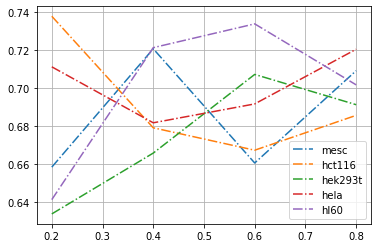

In [27]:
mesc=data[data['data']=='mesc']
hct116=data[data['data']=='hct116']
hek293t=data[data['data']=='hek293t']
hela=data[data['data']=='hela']
hl60=data[data['data']=='hl60']
plt.plot([0.2,0.4,0.6,0.8],mesc['test_accuracy'],'-.',label='mesc')
plt.plot([0.2,0.4,0.6,0.8],hct116['test_accuracy'],'-.',label='hct116')
plt.plot([0.2,0.4,0.6,0.8],hek293t['test_accuracy'],'-.',label='hek293t')
plt.plot([0.2,0.4,0.6,0.8],hela['test_accuracy'],'-.',label='hela')
plt.plot([0.2,0.4,0.6,0.8],hl60['test_accuracy'],'-.',label='hl60')
plt.legend()
plt.grid()


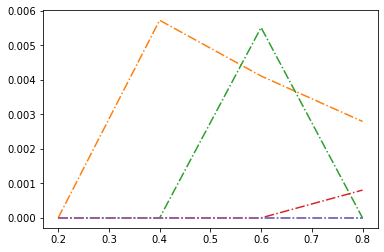

In [28]:
plt.plot([0.2,0.4,0.6,0.8],mesc['nmi'],'-.',label='mesc')
plt.plot([0.2,0.4,0.6,0.8],hct116['nmi'],'-.',label='hct116')
plt.plot([0.2,0.4,0.6,0.8],hek293t['nmi'],'-.',label='hek293t')
plt.plot([0.2,0.4,0.6,0.8],hela['nmi'],'-.',label='hela')
plt.plot([0.2,0.4,0.6,0.8],hl60['nmi'],'-.',label='hl60')

In [34]:
data.drop(columns=['test_accuracy']).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
nmi,0.0,0.0,0.0,0.0,0.0,0.005727,0.004111,0.002794,0.0,0.0,0.005516,0.0,0.0,0.0,0.000001,0.000806,0.0,0.0,0.0,0.0
data,mesc,mesc,mesc,mesc,hct116,hct116,hct116,hct116,hek293t,hek293t,hek293t,hek293t,hela,hela,hela,hela,hl60,hl60,hl60,hl60


In [40]:
percent=[20,40,60,80]*5

In [41]:
data['epoch']=percent

In [54]:
data.drop(columns=['test_accuracy']).groupby(['data','epoch']).mean().to_excel('nmi.xlsx')

In [2]:
# -*- coding:utf-8 -*-

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# import tensorflow as tf
# import keras.backend.tensorflow_backend as KTF
#
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.95
# session = tf.Session(config=config)
#
# KTF.set_session(session)

from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution1D, AveragePooling1D
from keras.layers.merge import concatenate
import numpy as np
import pandas as pd
from sklearn.svm import SVR
import scipy.stats as stats


def grna_preprocess(lines):
    length = 23
    data_n = len(lines)
    seq = np.zeros((data_n, length, 4), dtype=int)
    for l in range(data_n):
        data = lines[l]
        seq_temp = data
        for i in range(length):
            if seq_temp[i] in "Aa":
                seq[l, i, 0] = 1
            elif seq_temp[i] in "Cc":
                seq[l, i, 1] = 1
            elif seq_temp[i] in "Gg":
                seq[l, i, 2] = 1
            elif seq_temp[i] in "Tt":
                seq[l, i, 3] = 1
    return seq


def epi_preprocess(lines):
    length = 23
    data_n = len(lines)
    epi = np.zeros((data_n, length), dtype=int)
    for l in range(data_n):
        data = lines[l]
        epi_temp = data
        for i in range(length):
            if epi_temp[i] in "A":
                epi[l, i] = 1
            elif epi_temp[i] in "N":
                epi[l, i] = 0
    return epi


def preprocess(file_path, usecols):
    data = pd.read_csv(file_path, usecols=usecols)
    data = np.array(data)
    ctcf, dnase, h3k4me3, rrbs = epi_preprocess(data[:, 0]), epi_preprocess(data[:, 1]), epi_preprocess(data[:, 2]), epi_preprocess(data[:, 3])
    epi = []
    for i in range(len(data)):
        ctcf_t, dnase_t, h3k4me3_t, rrbs_t = pd.DataFrame(ctcf[i]), pd.DataFrame(dnase[i]), pd.DataFrame(h3k4me3[i]), pd.DataFrame(rrbs[i])
        epi_t = pd.concat([ctcf_t, dnase_t, h3k4me3_t, rrbs_t], axis=1)
        epi_t = np.array(epi_t)
        epi.append(epi_t)
    epi = np.array(epi)
    return epi


def load_data(train_file, test_file):
    train_data = pd.read_csv(train_file, usecols=[4, 9])
    train_data = np.array(train_data)
    train_seq, train_y = train_data[:, 0], train_data[:, 1]
    train_seq = grna_preprocess(train_seq)
    train_epi = preprocess(train_file, [5, 6, 7, 8])
    train_y = train_y.reshape(len(train_y), -1)

    test_data = pd.read_csv(test_file, usecols=[4, 9])
    test_data = np.array(test_data)
    test_seq, test_y = test_data[:, 0], test_data[:, 1]
    test_seq = grna_preprocess(test_seq)
    test_epi = preprocess(test_file, [5, 6, 7, 8])
    test_y = test_y.reshape(len(test_y), -1)
    return train_seq, test_seq, train_epi, test_epi, train_y, test_y
from sklearn.svm import SVC

# Build model
def build_model():
    dropout = 0.3
    seq_input = Input(shape=(23, 4))
    seq_conv1 = Convolution1D(256, 5, kernel_initializer='glorot_uniform', name='seq_conv_1')(seq_input)
    seq_act1 = Activation('relu', name='seq_activation1')(seq_conv1)
    seq_pool1 = AveragePooling1D(2, name='seq_pooling_1')(seq_act1)
    seq_drop1 = Dropout(dropout)(seq_pool1)

    seq_conv2 = Convolution1D(256, 5, kernel_initializer='glorot_uniform', name='seq_conv_2')(seq_drop1)
    seq_act2 = Activation('relu', name='seq_activation_2')(seq_conv2)
    seq_pool2 = AveragePooling1D(2, name='seq_pooling_2')(seq_act2)
    seq_drop2 = Dropout(dropout)(seq_pool2)
    seq_flat = Flatten()(seq_drop2)

    seq_dense1 = Dense(256, activation='relu', name='seq_dense_1')(seq_flat)
    seq_drop3 = Dropout(dropout)(seq_dense1)
    seq_dense2 = Dense(128, activation='relu', name='seq_dense_2')(seq_drop3)
    seq_drop4 = Dropout(dropout)(seq_dense2)
    seq_dense3 = Dense(64, activation='relu', name='seq_dense_3')(seq_drop4)
    seq_drop5 = Dropout(dropout)(seq_dense3)
    seq_out = Dense(40, activation='relu', name='seq_dense_4')(seq_drop5)

    epi_input = Input(shape=(23, 4))
    epi_conv1 = Convolution1D(256, 5, kernel_initializer='glorot_uniform', name='epi_conv_1')(epi_input)
    epi_act1 = Activation('relu', name='epi_activation_1')(epi_conv1)
    epi_pool1 = AveragePooling1D(2, name='epi_pooling_1')(epi_act1)
    epi_drop1 = Dropout(dropout)(epi_pool1)

    epi_conv2 = Convolution1D(256, 5, kernel_initializer='glorot_uniform', name='epi_conv_2')(epi_drop1)
    epi_act2 = Activation('relu', name='epi_activation_2')(epi_conv2)
    epi_pool2 = AveragePooling1D(2, name='epi_pooling_2')(epi_act2)
    epi_drop2 = Dropout(dropout)(epi_pool2)
    epi_flat = Flatten()(epi_drop2)

    epi_dense1 = Dense(256, activation='relu', name='epi_dense_1')(epi_flat)
    epi_drop3 = Dropout(dropout)(epi_dense1)
    epi_dense2 = Dense(128, activation='relu', name='epi_dense_2')(epi_drop3)
    epi_drop4 = Dropout(dropout)(epi_dense2)
    epi_dense3 = Dense(64, activation='relu', name='epi_dense_3')(epi_drop4)
    epi_drop5 = Dropout(dropout)(epi_dense3)
    epi_out = Dense(40, activation='relu', name='epi_dense_4')(epi_drop5)

    merged = concatenate([seq_out, epi_out], axis=-1)

    pretrain_model = Model(inputs=[seq_input, epi_input], outputs=[merged])

    # Load weights for the model
    pretrain_model.load_weights("weights.h5", by_name=True)

    prediction = Dense(1, activation='linear', name='prediction')(merged)
    model = Model([seq_input, epi_input], prediction)
    return merged, model



    # Calculate Spearman correlation coefficient
    # Spearman_correlation, _ = stats.stats.spearmanr(y_test, y_pred)

    # Print Spearman correlation result
    # print("Spearman correlation=%.3f" % (Spearman_correlation))
































In [3]:
def test_method(df):    
    metric = [] 
    scaler = MinMaxScaler()

    GC_count = [] 
    GC_content = [] 
    for seq in df['seq']:
        count,content = countGC(seq)
        GC_count.append(count)
        GC_content.append(content)
    psn_1 = [] 
    nc_1 = [] 
    for seq in df['seq']:
        nuc,pos = ncf(seq,1)
        psn_1.append(pos)
        nc_1.append(nuc)
    nc_11=[i.flatten() for i in nc_1]
    psn_2 = [] 
    nc_2 = [] 
    for seq in df['seq']:
        nuc2,pos2  = ncf(seq,2)
        psn_2.append(pos2)
        nc_2.append(nuc2)
    nc_21=[i.flatten() for i in nc_2]

    psn_3 = [] 
    nc_3 = [] 
    for seq in df['seq']:
        nuc3,pos3 = ncf(seq,3)
        psn_3.append(pos3)
        nc_3.append(nuc3)
    nc_31=[i.flatten() for i in nc_3]

    TMs =[]
    for seq in df['seq']: 
        TM = TM_cal(seq)
        TMs.append(TM)
    TMS=[i.flatten() for i in TMs]

    alpStat = [] 
    for seq in df['seq']: 
        al = binary_seqs(seq)
        alpStat.append(al)
    temp= [i.T for i in alpStat]
    alpha = [i.flatten() for i in temp]
    Trs = []
    ETs = []
    for seq in alpStat: 
        tr,et = TranEmis(seq.T,1)
        Trs.append(tr)
        ETs.append(et)
    df['GCcount']=GC_count
    df['GC_content']=GC_content
    d=pd.get_dummies(df['data'])
    # d2=pd.get_dummies(df['score'],prefix="label")
    d3=pd.DataFrame(nc_11).add_prefix('nc1')
    d4=pd.DataFrame(psn_1).add_prefix('psn1')
    d5=pd.DataFrame(nc_21).add_prefix('nc2')
    d6=pd.DataFrame(psn_2).add_prefix('psn2')
    d7=pd.DataFrame(nc_31).add_prefix('nc3')
    d8=pd.DataFrame(psn_3).add_prefix('psn3')
    d9=pd.DataFrame(TMS).add_prefix('tms')
    d10=pd.DataFrame(alpha).add_prefix('alpStat')
    df_concat = pd.concat([df,d,d3,d4,d5,d6,d7,d8,d9,d10],axis=1)
    data = df_concat.drop_duplicates(subset=['seq','label'])
    data = data.fillna(1)
    # Resampling 
    count_class_1, count_class_0 = data.label.value_counts()
    df_class_0 = data[data['label'] == 0]
    df_class_1 = data[data['label'] == 1]
    df_class_1_under = df_class_1.sample(count_class_0)
    df_test_under = pd.concat([df_class_1_under, df_class_0], axis=0)
    df_test_under = df_test_under.sample(frac=1).reset_index()
    X = df_test_under.drop(columns=['seq','label','data']).values
    X = normalize(X)
    X_train = deepcopy(X)
    layers = [100,50,2]
    Y = df_test_under[['label']].values
    matrix = SNMF(X, Y, layers=layers, k=3, option='b')
    matrix.compute_factors(random_init=True)
    matrix.collector.drop(columns=['index'], inplace=True)
    return matrix

In [5]:
# df_1= pd.read_excel(path+"/maindata.xlsx",sheet_name=0) #read mesc
# df_2 = pd.read_excel(path+"/maindata.xlsx",sheet_name=1) #read hl60
# df_3 = pd.read_excel(path+"/maindata.xlsx",sheet_name=2) #read hela_hart
# df_4 = pd.read_excel(path+"/maindata.xlsx",sheet_name=3) #read HEK293T
df_5 = pd.read_excel(path+"/maindata.xlsx",sheet_name=4) #read HCT116
# df=pd.concat([df_1,df_2,df_3,df_4,df_5]).reset_index().drop(columns=['index'])
# # df=pd.concat([df_1,df_2]).reset_index().drop(columns=['index'])
# df=df.drop_duplicates(subset=['seq','label'])

if __name__ == '__main__':

    train_path = "/home/stephenvu/Downloads/CNN-SVR/data/training_example.csv"
    test_path = "/home/stephenvu/Downloads/CNN-SVR/data/testing_example.csv"

    # Load data
    seq_train, seq_test, epi_train, epi_test, y_train, y_test = load_data(train_path, test_path)
    matrix = test_method(df_5)
    merged, model = build_model()

    new_model = Model(model.inputs, outputs=[merged])
    x_train = new_model.predict([seq_train, epi_train])
    x_test = new_model.predict([seq_test, epi_test])

    x_train, x_test = np.array(x_train), np.array(x_test)

    # Select important features from initial CNN features
    selected_cnn_fea_cols = [17, 26, 9, 19, 30, 6, 12, 39, 36, 21, 22, 3, 25]
    x_train = x_train[:, selected_cnn_fea_cols]
    x_test = x_test[:, selected_cnn_fea_cols]

    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()

    clf = SVC(kernel="rbf", gamma=0.12, C=1.7)
    
    # Fit the SVR model according to the given training data
    clf.fit(matrix.X.T, matrix.Y.T.flatten())

    # Perform regression on samples in x_test
    y_pred = clf.predict(matrix.X2.T)
    print(accuracy_score(matrix.Y2.T.flatten(),y_pred))


g shape: (2129, 1904)
0.47535596933187296
